In [3]:
! pip install bootstrapped

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=3a8108c464f3a6a53dc69320dfc42df19ac615e293c95d94124897aa6d0a9e1c
  Stored in directory: /root/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped


In [5]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 4.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.stats.proportion as proportion
import math
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import phik
from copy import deepcopy
import itertools
import collections
from copy import deepcopy

# **Чтение и изучение данных**

In [8]:
df = pd.read_csv('/content/supermarket_sales - Sheet1.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [12]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('%', '')
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [13]:
df.axes

[RangeIndex(start=0, stop=1000, step=1),
 Index(['invoice_id', 'branch', 'city', 'customer_type', 'gender',
        'product_line', 'unit_price', 'quantity', 'tax_5', 'total', 'date',
        'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income',
        'rating'],
       dtype='object')]

In [15]:
null_cols = df.columns[df.isna().any()]
null_cols

Index([], dtype='object')

In [16]:
df.memory_usage()

Index                       128
invoice_id                 8000
branch                     8000
city                       8000
customer_type              8000
gender                     8000
product_line               8000
unit_price                 8000
quantity                   8000
tax_5                      8000
total                      8000
date                       8000
time                       8000
payment                    8000
cogs                       8000
gross_margin_percentage    8000
gross_income               8000
rating                     8000
dtype: int64

In [19]:
df.select_dtypes(include = ['object'])

,invoice_id,branch,city,customer_type,gender,product_line,date,time,payment
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,1/5/2019,13:08,Ewallet
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,3/8/2019,10:29,Cash
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,3/3/2019,13:23,Credit card
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,1/27/2019,20:33,Ewallet
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,2/8/2019,10:37,Ewallet
...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,1/29/2019,13:46,Ewallet
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,3/2/2019,17:16,Ewallet
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,2/9/2019,13:22,Cash
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,2/22/2019,15:33,Cash


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   invoice_id               1000 non-null   object 
 1   branch                   1000 non-null   object 
 2   city                     1000 non-null   object 
 3   customer_type            1000 non-null   object 
 4   gender                   1000 non-null   object 
 5   product_line             1000 non-null   object 
 6   unit_price               1000 non-null   float64
 7   quantity                 1000 non-null   int64  
 8   tax_5                    1000 non-null   float64
 9   total                    1000 non-null   float64
 10  date                     1000 non-null   object 
 11  time                     1000 non-null   object 
 12  payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross_margin_percentage  

In [23]:
df['date'] = pd.to_datetime(df['date'])

In [25]:
df = df.drop_duplicates().reset_index(drop = True)

In [26]:
length = df.shape[0]
size = df.size

# **Предобработка**

In [27]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [60]:
def custom_hist(df : pd.Series):
  fig = plt.figure(figsize = (6, 6))
  ax = fig.add_subplot()
  plt.hist(df, color = 'red', edgecolor = 'skyblue', bins = 20, density = True, label = 'Hist')
  plt.axvline(np.mean(df), linestyle = 'dashed', linewidth = 2, color = 'blue', label = 'average')
  plt.axvline(np.quantile(df, 0.25), linestyle = 'dashed', linewidth = 2, color = 'orange', label = '0.25Procentile')
  plt.axvline(np.quantile(df, 0.75), linestyle = 'dashed', linewidth = 2, color = 'orange', label = '0.75Procentile')
  plt.title('Histogram')
  plt.xlabel('Values')
  plt.ylabel('Counter of values')
  plt.xticks(rotation = 45)
  plt.legend(loc = 'best')
  plt.minorticks_on()
  plt.grid(which = 'minor', ls = '--', linewidth = 0.2)
  plt.show();


def describe_columns(df : pd.Series):
  print(f'Количество пропусков: {df.isna().mean()}')
  print(f'Тип данных: {df.dtypes}')
  print(f'Количество уникальных элементов : {len(frozenset(list(df)))}')
  print(f'Is empty ? {df.empty}')

In [30]:
# invoice_id

In [31]:
describe_columns(df['invoice_id'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 1000
Is empty ? False


In [32]:
length

1000

In [33]:
# branch

In [34]:
describe_columns(df['branch'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 3
Is empty ? False


In [36]:
df['branch'].unique()

array(['A', 'C', 'B'], dtype=object)

In [37]:
df.groupby('branch')['total'].agg(['count', 'sum']).sort_values('count', ascending = False).reset_index()

,branch,count,sum
0,A,340,106200.3705
1,B,332,106197.6720
2,C,328,110568.7065


In [38]:
# city

In [39]:
describe_columns(df['city'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 3
Is empty ? False


In [41]:
df.groupby('city')['total'].agg(['count', 'sum']).sort_values('count', ascending = False).reset_index()

,city,count,sum
0,Yangon,340,106200.3705
1,Mandalay,332,106197.6720
2,Naypyitaw,328,110568.7065


In [42]:
# customer_type

In [43]:
describe_columns(df['customer_type'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 2
Is empty ? False


In [45]:
df.groupby('customer_type')['total'].agg(['count', 'sum']).sort_values('count', ascending = False).reset_index()

,customer_type,count,sum
0,Member,501,164223.444
1,Normal,499,158743.305


In [46]:
# gender

In [47]:
describe_columns(df['gender'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 2
Is empty ? False


In [49]:
df.groupby('gender')['total'].agg(['count', 'sum']).sort_values('count', ascending = False).reset_index()


,gender,count,sum
0,Female,501,167882.925
1,Male,499,155083.824


In [50]:
# product_line

In [51]:
describe_columns(df['product_line'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 6
Is empty ? False


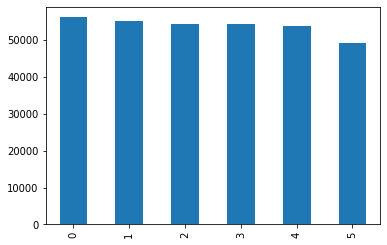

In [54]:
df.groupby('product_line')['total'].agg(['count', 'sum']).sort_values('sum', ascending = False).reset_index()['sum'].plot(kind = 'bar')


In [56]:
df.groupby('product_line')['total'].agg(['count', 'sum']).sort_values('sum', ascending = False).reset_index()# Food and beverages


,product_line,count,sum
0,Food and beverages,174,56144.8440
1,Sports and travel,166,55122.8265
2,Electronic accessories,170,54337.5315
3,Fashion accessories,178,54305.8950
4,Home and lifestyle,160,53861.9130
5,Health and beauty,152,49193.7390


In [57]:
# unit_price

In [58]:
describe_columns(df['unit_price'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 943
Is empty ? False


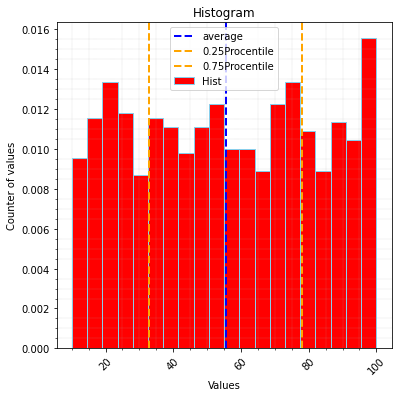

In [63]:
custom_hist(df['unit_price']) # unimodalno

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


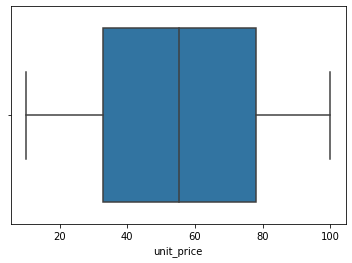

In [64]:
sns.boxplot(df['unit_price'])

In [65]:
df['unit_price'].describe(include = 'all')

count    1000.000000
mean       55.672130
std        26.494628
min        10.080000
25%        32.875000
50%        55.230000
75%        77.935000
max        99.960000
Name: unit_price, dtype: float64

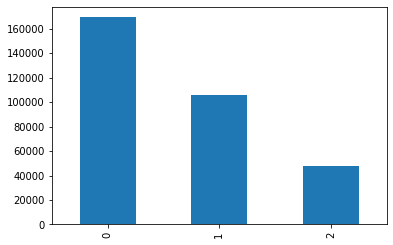

In [67]:
df['intervals'] = pd.qcut(df['unit_price'], 3, labels = ['low', 'med', 'high'], duplicates = 'drop')
df.groupby('intervals')['total'].agg(['sum']).sort_values('sum', ascending = False).reset_index()['sum'].plot(kind = 'bar')

In [69]:
df = df.drop(['intervals'], axis = 1)

In [70]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [71]:
# quantity

In [74]:
describe_columns(df['quantity'])

Количество пропусков: 0.0
Тип данных: int64
Количество уникальных элементов : 10
Is empty ? False


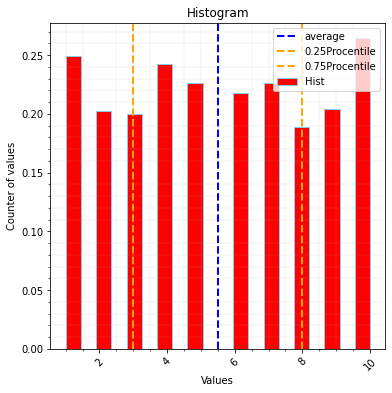

In [75]:
custom_hist(df['quantity'])

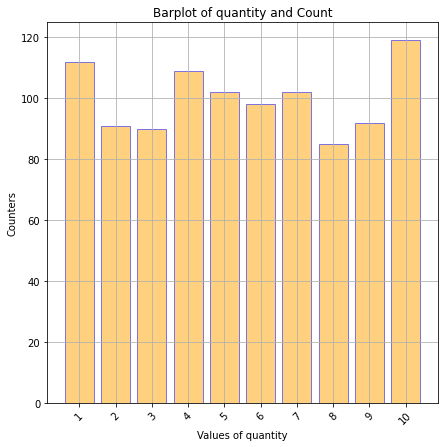

In [77]:
t = df.groupby('quantity')['city'].agg(['count']).reset_index()
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.bar(np.array(t['quantity']), t['count'], alpha = 0.5, color = 'orange', edgecolor = 'blue', label = 'barp')
plt.title('Barplot of quantity and Count')
plt.xlabel('Values of quantity')
plt.ylabel('Counters')
plt.xticks(t['quantity'].values ,rotation = 45)
plt.grid()
plt.show();

In [82]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [83]:
# tax_5 percent

In [85]:
describe_columns(df['tax_5'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 990
Is empty ? False


In [87]:
len(df['total'].unique()) == len(df['tax_5'].unique())

True

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


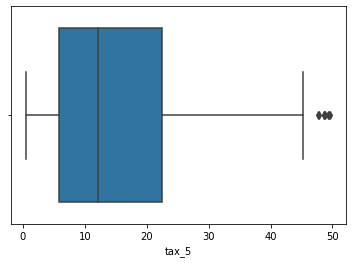

In [88]:
sns.boxplot(df['tax_5'])

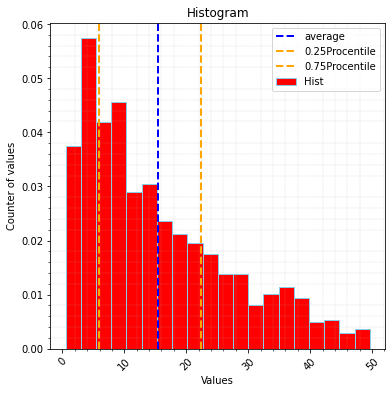

In [89]:
custom_hist(df['tax_5'])

In [92]:
df.loc[df['tax_5'] > 48]

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
167,687-47-8271,A,Yangon,Normal,Male,Fashion accessories,98.98,10,49.490,1039.290,2019-02-08,16:20,Credit card,989.8,4.761905,49.490,8.7
350,860-79-0874,C,Naypyitaw,Member,Female,Fashion accessories,99.30,10,49.650,1042.650,2019-02-15,14:53,Credit card,993.0,4.761905,49.650,6.6
422,271-88-8734,C,Naypyitaw,Member,Female,Fashion accessories,97.21,10,48.605,1020.705,2019-02-08,13:00,Credit card,972.1,4.761905,48.605,8.7
557,283-26-5248,C,Naypyitaw,Member,Female,Food and beverages,98.52,10,49.260,1034.460,2019-01-30,20:23,Ewallet,985.2,4.761905,49.260,4.5
699,751-41-9720,C,Naypyitaw,Normal,Male,Home and lifestyle,97.50,10,48.750,1023.750,2019-01-12,16:18,Ewallet,975.0,4.761905,48.750,8.0
792,744-16-7898,B,Mandalay,Normal,Female,Home and lifestyle,97.37,10,48.685,1022.385,2019-01-15,13:48,Credit card,973.7,4.761905,48.685,4.9
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.690,1022.490,2019-03-02,17:16,Ewallet,973.8,4.761905,48.690,4.4


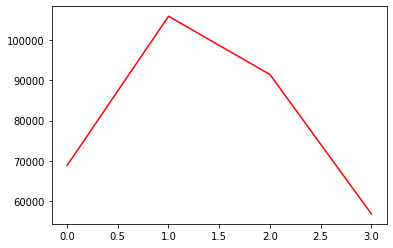

In [95]:
df['intervals'] = pd.cut(df['tax_5'], bins = 4)
df.groupby('intervals')['total'].agg(['count', 'sum', 'mean']).reset_index().sort_values('mean', ascending = False)['sum'].plot(color = 'red')

In [96]:
df = df.drop(['intervals'], axis = 1)

In [97]:
# total

In [98]:
describe_columns(df.total)

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 990
Is empty ? False


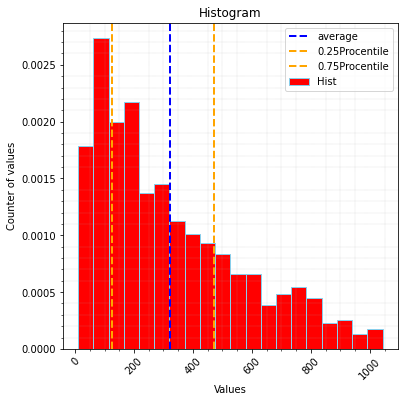

In [99]:
custom_hist(df['total'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


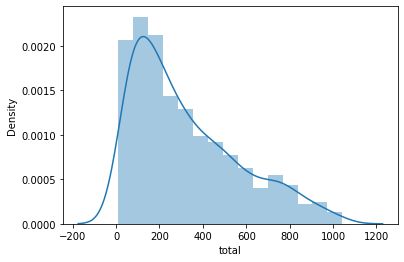

In [101]:
sns.distplot(df['total']);

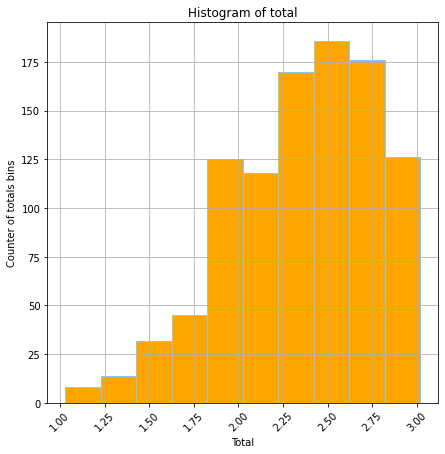

In [104]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.hist(np.log10(df['total']), color = 'orange', edgecolor = 'skyblue', bins = 10, label = 'hist')
plt.title('Histogram of total') 
plt.xlabel('Total')
plt.ylabel('Counter of totals bins')
plt.xticks(rotation = 45)
plt.grid()
plt.show();

In [105]:
# date

In [106]:
describe_columns(df['date'])

Количество пропусков: 0.0
Тип данных: datetime64[ns]
Количество уникальных элементов : 89
Is empty ? False


In [117]:
df = df.drop(['year'], axis = 1)

In [118]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [134]:
df['month'] = df['month'].astype('int32')

In [136]:
df.groupby('month')['total'].agg(['count', 'sum']).reset_index().sort_values('sum', ascending = False)

,month,count,sum
0,1,352,116291.868
2,3,345,109455.507
1,2,303,97219.374


In [137]:
# time

In [138]:
describe_columns(df['time'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 506
Is empty ? False


In [140]:
df['time'] = df['time'].transform(lambda x: str(x)[0:2])
df['time'] = df['time'].astype('int64')

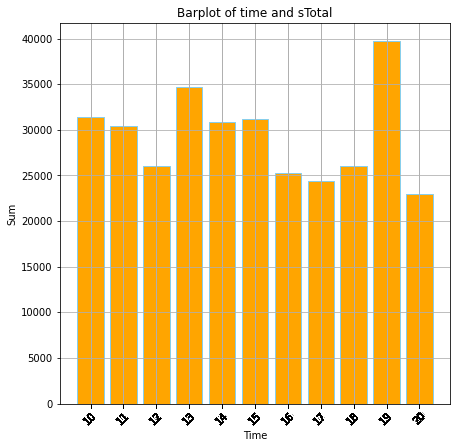

In [141]:
t = df.groupby('time')['total'].agg(['count', 'sum']).reset_index()
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.bar(t['time'].values, t['sum'], color = 'orange', edgecolor = 'skyblue', label = 'barp')
plt.title('Barplot of time and sTotal')
plt.xlabel('Time')
plt.ylabel('Sum')
plt.xticks(df['time'].values, rotation = 45)
plt.grid()
plt.show();

In [143]:
t.sort_values('sum', ascending = False)

,time,count,sum
9,19,113,39699.5130
3,13,103,34723.2270
0,10,101,31421.4810
5,15,102,31179.5085
4,14,83,30828.3990
1,11,90,30377.3295
2,12,89,26065.8825
8,18,93,26030.3400
6,16,77,25226.3235
7,17,74,24445.2180


In [144]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,month
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,4.761905,26.1415,9.1,1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,4.761905,3.8200,9.6,3
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,4.761905,16.2155,7.4,3
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,4.761905,23.2880,8.4,1
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,4.761905,30.2085,5.3,2


In [145]:
# payment

In [147]:
describe_columns(df['payment'])

Количество пропусков: 0.0
Тип данных: object
Количество уникальных элементов : 3
Is empty ? False


In [148]:
df.groupby('payment')['total'].agg(['count', 'sum']).sort_values('sum', ascending = False).reset_index()

,payment,count,sum
0,Cash,344,112206.570
1,Ewallet,345,109993.107
2,Credit card,311,100767.072


In [149]:
# cogs

In [152]:
describe_columns(df['cogs'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 990
Is empty ? False


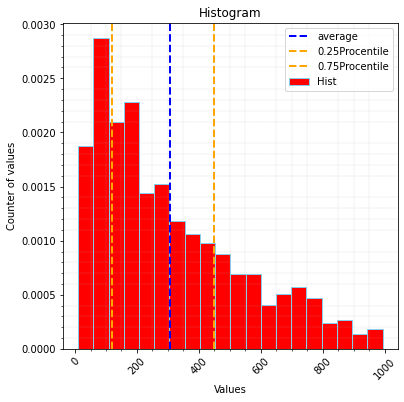

In [153]:
custom_hist(df['cogs'])

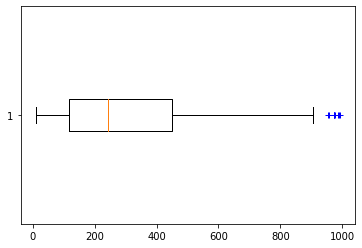

In [156]:
plt.boxplot(df['cogs'], vert = False, sym = 'b+')
plt.show();

In [158]:
len(df.loc[df['cogs'] > 900])

11

In [159]:
df = df.loc[df['cogs'] <= 900]

In [160]:
# gross_margin_percentage

In [161]:
describe_columns(df['gross_margin_percentage'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 1
Is empty ? False


In [162]:
# gross_income

In [164]:
describe_columns(df['gross_income'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 979
Is empty ? False


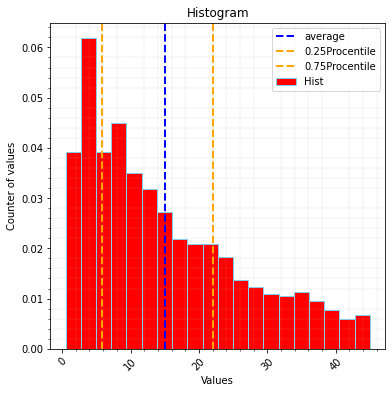

In [165]:
custom_hist(df.gross_income)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


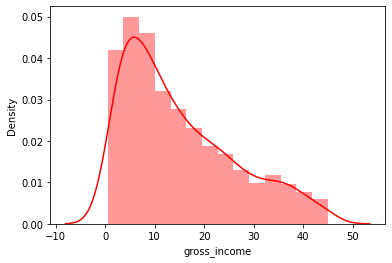

In [167]:
sns.distplot(df['gross_income'], color = 'red')

In [168]:
# rating

In [169]:
describe_columns(df['rating'])

Количество пропусков: 0.0
Тип данных: float64
Количество уникальных элементов : 61
Is empty ? False


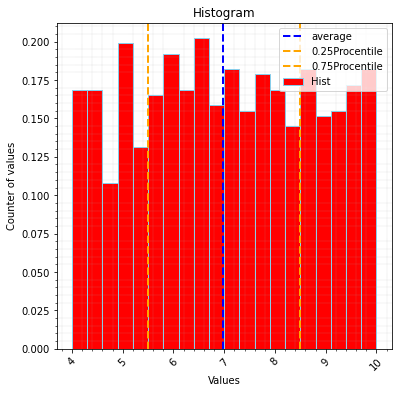

In [170]:
custom_hist(df['rating'])

# **Работа с данными**

In [171]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,month
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,4.761905,26.1415,9.1,1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,4.761905,3.8200,9.6,3
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,4.761905,16.2155,7.4,3
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,4.761905,23.2880,8.4,1
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,4.761905,30.2085,5.3,2


In [177]:
d = df.groupby(['gender', 'city'])['total'].agg(['count', 'sum']).sort_values('sum', ascending = False).reset_index()

In [178]:
d

,gender,city,count,sum
0,Female,Naypyitaw,174,57585.5280
1,Male,Mandalay,170,53269.3770
2,Female,Yangon,160,52317.3420
3,Male,Yangon,178,51891.9135
4,Female,Mandalay,160,50883.4200
5,Male,Naypyitaw,147,45905.6535


In [189]:
def castomize_gender_city(df : pd.DataFrame, city_columns):
  for city in city_columns:
    data = df.loc[df['city'] == city]
    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot()
    plt.bar(data['gender'].values, data['sum'], color = 'orange', edgecolor = 'black', alpha = 0.5)
    plt.style.use('dark_background')
    plt.title(f'Barplot of gender and city {city}')
    plt.xticks(data['gender'].values, rotation = 20)
    plt.xlabel('Gender')
    plt.ylabel(f'{city}')
    plt.show();

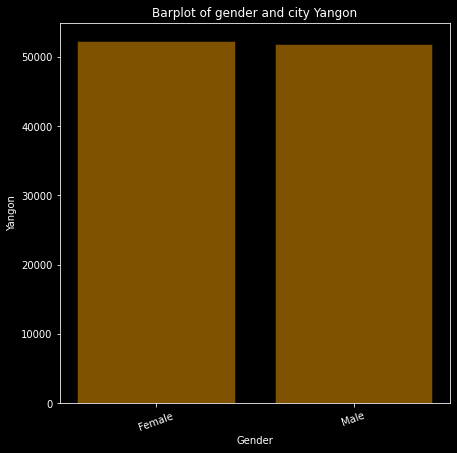

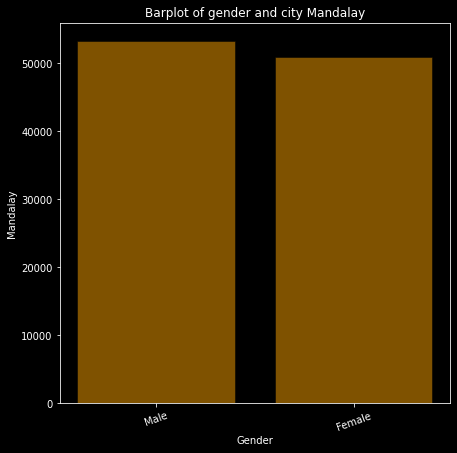

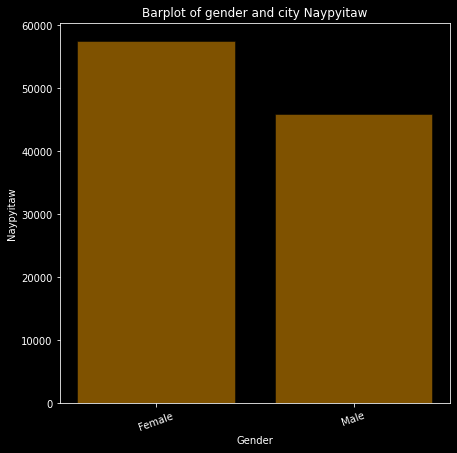

In [191]:
castomize_gender_city(d, ['Yangon', 'Mandalay', 'Naypyitaw'])

In [192]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,month
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,4.761905,26.1415,9.1,1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,4.761905,3.8200,9.6,3
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,4.761905,16.2155,7.4,3
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,4.761905,23.2880,8.4,1
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,4.761905,30.2085,5.3,2


In [195]:
t = df.groupby(['product_line', 'payment'])['gross_income'].agg(['count', 'sum']).reset_index()

In [196]:
t

,product_line,payment,count,sum
0,Electronic accessories,Cash,71,987.1420
1,Electronic accessories,Credit card,46,734.6675
2,Electronic accessories,Ewallet,53,865.6920
3,Fashion accessories,Cash,57,838.7520
4,Fashion accessories,Credit card,53,677.7345
5,Fashion accessories,Ewallet,65,921.7635
6,Food and beverages,Cash,57,914.8035
7,Food and beverages,Credit card,61,963.5805
8,Food and beverages,Ewallet,55,745.9200
9,Health and beauty,Cash,48,773.2790


In [204]:
frozen_set = list(frozenset(t['product_line'].to_list()))

In [206]:
def compare_product_and_payments(df : pd.DataFrame, products : list):
  for product in products:
    data = df.loc[df['product_line'] == product]
    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot()
    plt.bar(data['payment'].values, data['sum'], alpha = 0.6, color = 'orange', edgecolor = 'blue', label = f'product is {product}')
    plt.legend(loc = 'best')
    plt.title('Barplot of products and sum') 
    plt.xlabel('payment')
    plt.ylabel('Sum')
    plt.xticks(data['payment'].values, rotation = 45)
    plt.grid()
    plt.show();

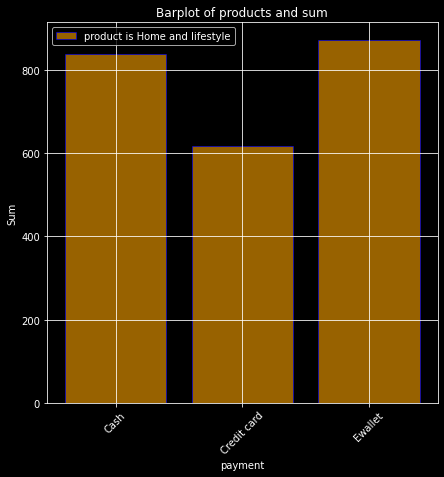

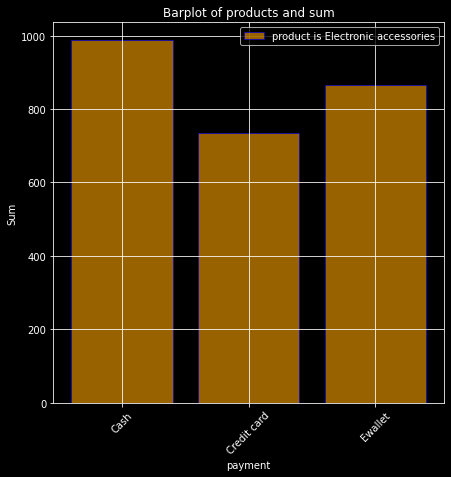

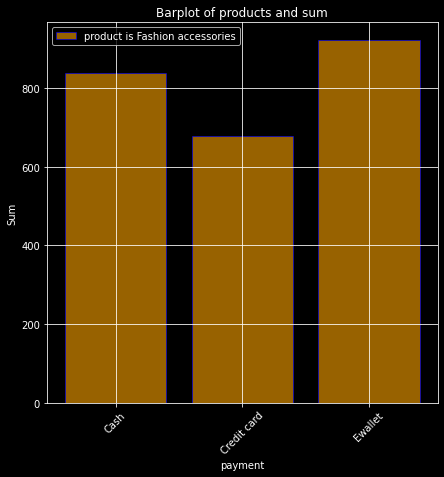

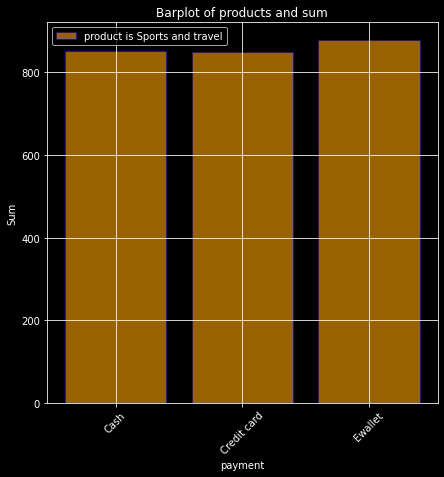

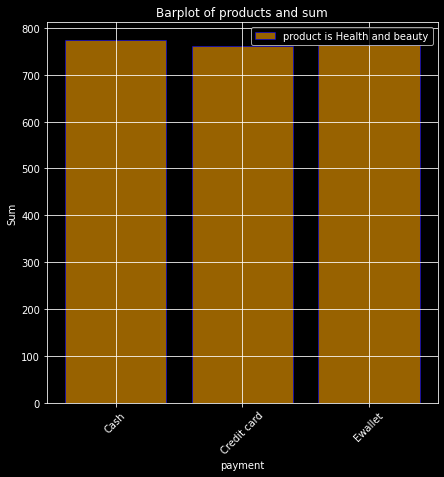

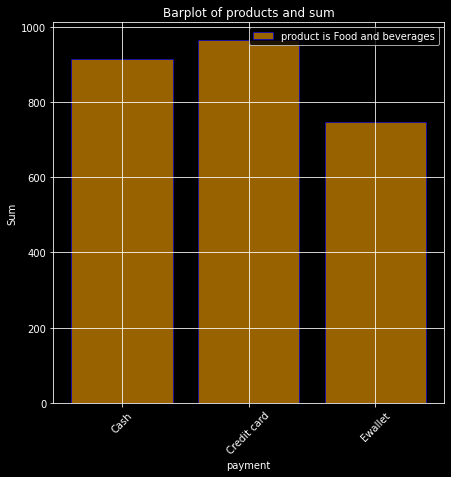

In [208]:
compare_product_and_payments(t, frozen_set)

In [209]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,month
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,4.761905,26.1415,9.1,1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,4.761905,3.8200,9.6,3
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,4.761905,16.2155,7.4,3
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,4.761905,23.2880,8.4,1
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,4.761905,30.2085,5.3,2


# **Проверка гипотез**

Гипотеза 1: Средние продажи по Naypyitaw выше чем у Yangon

H0) --> mean(N) == mean(Yangon)

H1) --> mean(N) != mean(Yangon)

In [211]:
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,month
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,4.761905,26.1415,9.1,1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,4.761905,3.8200,9.6,3
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,4.761905,16.2155,7.4,3
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,4.761905,23.2880,8.4,1
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,4.761905,30.2085,5.3,2


In [213]:
y = df.loc[df['city'] == 'Yangon']

In [212]:
n = df.loc[df['city'] == 'Naypyitaw']

In [225]:
def two_histgrams(df1 : pd.Series, df2 : pd.Series):
    plt.style.use('classic')
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot()
    plt.hist(df1, color = 'orange', edgecolor = 'red', bins = 20, label = 'first DF', alpha = 0.3)
    plt.hist(df2, color = 'blue', edgecolor = 'white', bins = 20, label = 'second DF', alpha = 0.5)
    plt.axvline(np.mean(df1), linestyle = 'dashed', linewidth = 2, color = 'pink', label = 'average First DF') 
    plt.axvline(np.mean(df2), linestyle = 'dashed', linewidth = 2, color = 'red', label = 'average Second DF') 
    df1.plot.kde(color = 'red')
    df2.plot.kde(color = 'white')
    plt.title('Two histograms')
    plt.xlabel('Values of histograms')
    plt.ylabel('Counters values of 2 histograms')
    plt.xticks(rotation = 40)
    plt.grid()
    plt.show()


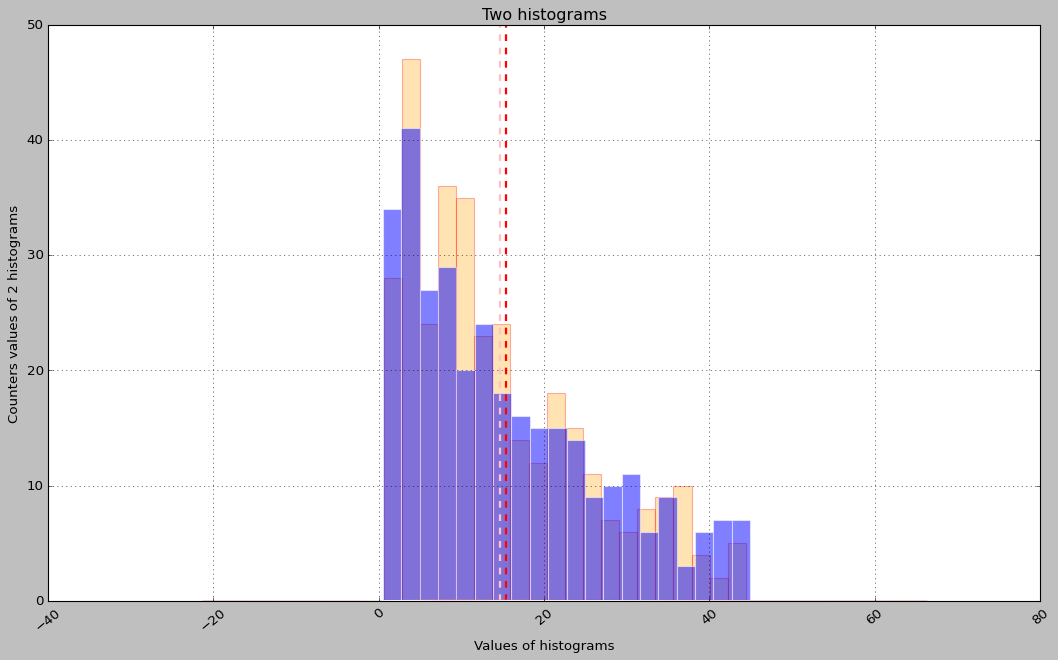

In [226]:
two_histgrams(y['gross_income'], n['gross_income'])

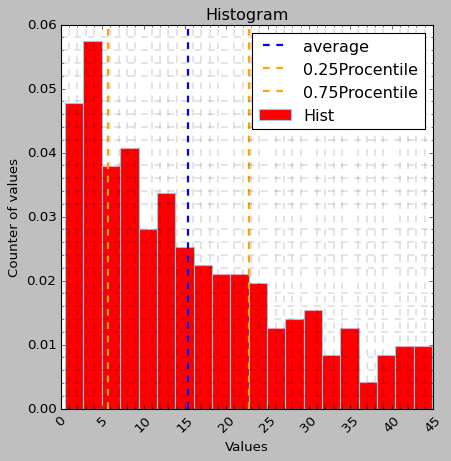

In [227]:
custom_hist(n['gross_income'])

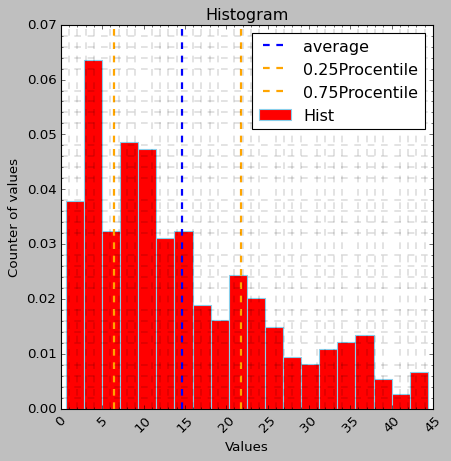

In [228]:
custom_hist(y['gross_income'])

In [230]:
table, pvalue = scipy.stats.shapiro(n['gross_income'])

pvalue > 0.01


False

In [231]:
table, pvalue = scipy.stats.shapiro(y['gross_income'])

pvalue > 0.01

False

In [237]:
stastics, pvalue = scipy.stats.levene(n['gross_income'], y['gross_income'])

if pvalue > 0.01:
    print(f'Dispersii ravi pvalue is {pvalue}')
else:
    print(f'Net osnovaniy uttverjdat chto dispersii ravni')

Dispersii ravi pvalue is 0.10721557624585691


In [239]:
stastics, pvalue = scipy.stats.fligner(n['gross_income'], y['gross_income'])

if pvalue > 0.01:
    print(f'Dispersii ravi pvalue is {pvalue}')
else:
    print(f'Net osnovaniy uttverjdat chto dispersii ravni')

Dispersii ravi pvalue is 0.05639042360474948


In [246]:
import random as rn
def generate_bootstrap_mean(first_col : pd.Series, second_col : pd.Series):
 
  length_first_col = first_col.shape[0]
  length_second_col = second_col.shape[0]
  first_col = list(first_col)
  second_col = list(second_col)
  result_stack = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_first_col // 2):
      random = rn.randint(0, length_first_col - 1)
      stack += [first_col[random]]
    
    stack = pd.Series(stack)
    result_stack += [np.var(stack)]
 
  second_result = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_second_col // 2):
      random = rn.randint(0, length_second_col - 1)
      stack += [second_col[random]]
    
    stack = pd.Series(stack)
    second_result += [np.var(stack)]
  return pd.Series(result_stack) - pd.Series(second_result)

In [247]:
arr = generate_bootstrap_mean(n['gross_income'], y['gross_income'])

In [253]:
left = np.mean(arr) - 2 * np.std(arr)
right = np.mean(arr) + 2 * np.std(arr)

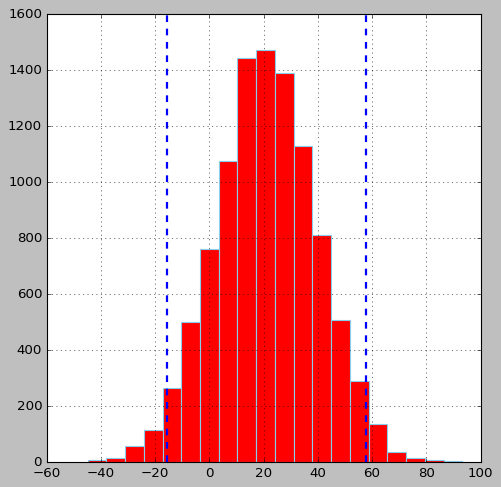

In [255]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.hist(arr,  color = 'red', edgecolor = 'skyblue', bins = 20)
plt.axvline(left, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.axvline(right, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.grid()
plt.show();

In [256]:
alpha = 0.01

In [258]:
stastics, pvalue = scipy.stats.mannwhitneyu(n['gross_income'], y['gross_income'])

if pvalue > alpha:
    print(f'Нет оснований отвергать нулевую гипотезу')
else:
    print(f'Отвергаем нулевую гипотезу')

Нет оснований отвергать нулевую гипотезу


In [260]:
stastics, pvalue = scipy.stats.ttest_ind(n['gross_income'], y['gross_income'])

if pvalue > alpha:
    print(f'Нет оснований отвергать нулевую гипотезу')
else:
    print(f'Отвергаем нулевую гипотезу')

Нет оснований отвергать нулевую гипотезу


In [263]:
import random as rn
def generate_bootstrap_mean_1(first_col : pd.Series, second_col : pd.Series):
 
  length_first_col = first_col.shape[0]
  length_second_col = second_col.shape[0]
  first_col = list(first_col)
  second_col = list(second_col)
  result_stack = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_first_col // 2):
      random = rn.randint(0, length_first_col - 1)
      stack += [first_col[random]]
    
    stack = pd.Series(stack)
    result_stack += [np.mean(stack)]
 
  second_result = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_second_col // 2):
      random = rn.randint(0, length_second_col - 1)
      stack += [second_col[random]]
    
    stack = pd.Series(stack)
    second_result += [np.mean(stack)]
  return pd.Series(result_stack) - pd.Series(second_result)

In [264]:
arr = generate_bootstrap_mean_1(n['gross_income'], y['gross_income'])

In [265]:
left = np.mean(arr) - 2 * np.std(arr)
right = np.mean(arr) + 2 * np.std(arr)

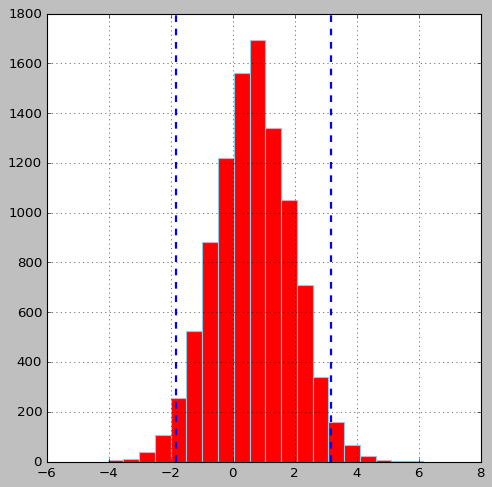

In [266]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot()
plt.hist(arr,  color = 'red', edgecolor = 'skyblue', bins = 20)
plt.axvline(left, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.axvline(right, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.grid()
plt.show();